In [2]:
import seml
import pandas as pd
import glob
import mudata as mu
import deconvatac as de

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
def get_proportions(adata):
    df = pd.DataFrame(adata.obsm["proportions"], columns=adata.uns["proportion_names"], index=adata.obs_names)
    return df

In [4]:
df = seml.get_results('deconvolution', to_data_frame=True)

100%|██████████| 7/7 [00:00<00:00, 2410.32it/s]


In [35]:
res = pd.read_csv(df["result.result_path"][0], index_col=0)

In [36]:
#res.columns = res.columns.to_series().str.split("q05cell_abundance_w_sf_", expand=True).loc[:, 1].values
res.index = res.index.astype(str)

In [37]:
res = res.div(res.sum(axis=1), axis=0)

In [38]:
spatial = mu.read(df["config.data.mdata_spatial_path"][0])

In [39]:
targets = get_proportions(spatial[df["config.data.modality"][0]])

In [40]:
res = res.loc[targets.index, targets.columns]

In [ ]:
metrics = {}

In [ ]:
metrics.update({

In [ ]:
de.tl.jsd(res, targets)

0.33110149616874796

In [ ]:
de.tl.rmse(res, targets)

0.097341299742551

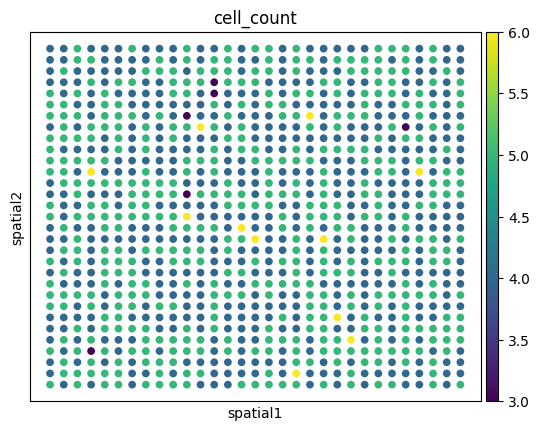

In [22]:
import scanpy as sc
sc.pl.embedding(spatial[df["config.data.modality"][0]], basis="spatial", color="cell_count")

In [29]:
spatial[df["config.data.modality"][0]].obs = (
    spatial[df["config.data.modality"][0]].obs.join(targets).join(res, rsuffix="_deconv")
)

In [31]:
spatial[df["config.data.modality"][0]].obs

,cell_count,Adipocyte,Atrial Cardiomyocyte,Endothelial cell,Fibroblast,Lymphatic Endothelial cell,Lymphoid,Mast cell,Mesothelial cell,Mural cell,...,Endothelial cell_deconv,Fibroblast_deconv,Lymphatic Endothelial cell_deconv,Lymphoid_deconv,Mast cell_deconv,Mesothelial cell_deconv,Mural cell_deconv,Myeloid_deconv,Neural cell_deconv,Ventricular Cardiomyocyte_deconv
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.40,0.60,...,1.149768e-06,1.312830e-06,4.782205e-07,0.028617,0.002698,0.015511,0.936785,1.120185e-07,0.016382,1.971016e-07
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.00,0.25,...,5.900625e-07,4.438190e-07,6.704035e-07,0.118916,0.736315,0.000362,0.144348,1.151727e-06,0.000056,2.356813e-07
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.60,0.40,...,1.532385e-06,7.055429e-07,4.048387e-07,0.012541,0.000962,0.883672,0.101276,5.155251e-07,0.001545,2.353609e-07
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00,...,8.998106e-08,4.459206e-08,1.852111e-08,0.008894,0.001309,0.868955,0.114989,2.868987e-08,0.005852,7.245349e-09
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.60,0.20,...,8.584917e-07,3.875809e-07,2.732702e-07,0.020912,0.004476,0.772568,0.198043,2.924049e-07,0.003999,1.393418e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.60,0.20,...,2.526301e-05,1.125713e-05,1.074749e-05,0.040920,0.017116,0.679625,0.250076,5.621666e-06,0.012183,4.021655e-06
957,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.50,0.25,...,6.061429e-08,2.985640e-08,1.308838e-08,0.015448,0.012047,0.763556,0.194392,1.691389e-08,0.014557,3.704520e-09
958,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60,0.20,0.20,...,3.900441e-07,2.849735e-07,4.184850e-07,0.123737,0.609854,0.000812,0.265486,7.172927e-07,0.000108,1.432258e-07
959,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.50,0.50,...,6.836092e-06,6.019035e-06,3.278529e-06,0.040576,0.004763,0.190652,0.726212,8.230489e-07,0.037765,1.153199e-06


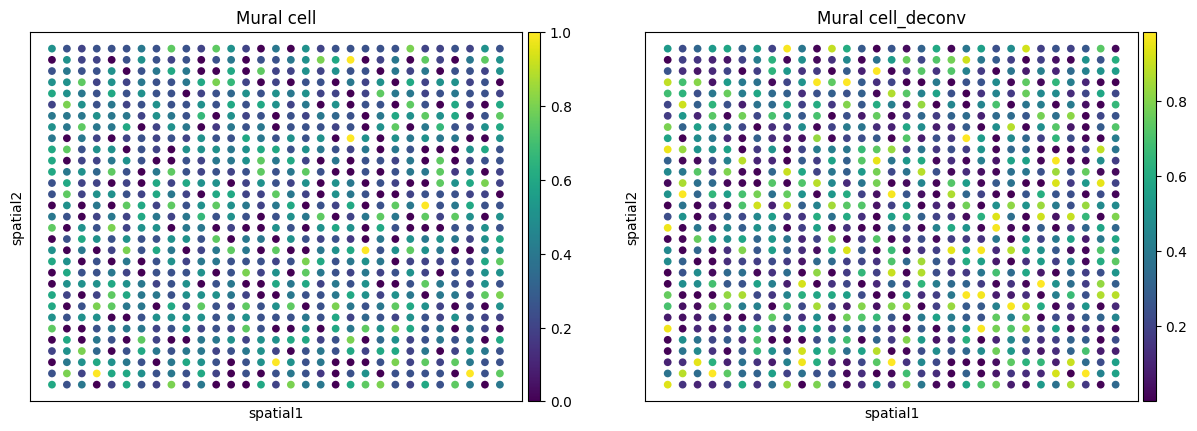

In [32]:
sc.pl.embedding(
    spatial[df["config.data.modality"][0]],
    basis="spatial",
    color=["Mural cell", "Mural cell_deconv"],
)